CDI ANNUAL ELECTRICITY COST SAVINGS USING CDI_ELIGIBLE.CSV DATASET (MULTI FAMILY, RETAIL, OFFICE)


In [396]:
import pandas as pd
import numpy as np

import patsy                           # provides a syntax for specifying models  
import statsmodels.api as sm           # provides statistical models like ols, gmm, anova, etc...
import statsmodels.formula.api as smf  # provides a way to directly spec models from formulas

from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [397]:
# Import simulation data
simdata = pd.read_csv("Free (Basic).csv")
# Import HVAC data
hvac = pd.read_csv("LA_HVAC_results.csv")
print('Pre-merge:','\n',simdata.shape, '\n', hvac.shape)

# Merge dataframes
merged = pd.merge(simdata, hvac, left_on="ubid", right_on="LA_bid")
print("Post-merge:","\n", merged.shape)
#merged.head()

# Selecting only buidlings from Simulation
merged = merged[merged['retrofit package name'] == "ECM Package 1"]

# Renaming some columns
merged = merged.rename(columns={"year built (year)": "year_built", 
                                "total floor area (m2)": "floor_area", 
                                "baseline annual site energy use intensity (kWh/m2)": "site_eui",
                                "baseline annual water for water systems (m3/m2)": "annual_water",
                                "annual electricity cost saving ($)": "elec_cost_saving"})

# Changing units
merged["annual_water"] = merged["annual_water"]*merged["floor_area"]
merged["annual_water"] = merged["annual_water"]*264.172
merged["floor_area"] = merged["floor_area"]*10.7639
merged["annual_water"] = merged["annual_water"]/merged["floor_area"]

Pre-merge: 
 (486, 105) 
 (243, 5)
Post-merge: 
 (486, 110)


In [398]:
EBEWE_buildings = pd.read_csv("CDI_eligible.csv") 
unique = EBEWE_buildings.replace('Not Available',np.NaN)
unique = EBEWE_buildings.replace('',np.NaN)
unique = EBEWE_buildings.replace(' ',np.NaN)

# Changing units
unique["annual_water"] = (unique["annual_water"]*1000)/unique['floor_area']

unique.shape

In [399]:
# Selecting only multi-family housing
regdata1 = merged[(merged["building type"] == "Multi Family House")]
regdata1.shape

(118, 110)

In [400]:
regdata1 = regdata1[["elec_cost_saving","floor_area","site_eui","annual_water"]]

# Scaling the data
#scaler = MinMaxScaler()
#scaler.fit(regdata1[["floor_area","site_eui","annual_water"]])
#regdata1[["floor_area","site_eui","annual_water"]] = scaler.transform(regdata1[["floor_area","site_eui","annual_water"]])

regdata1.head()

,elec_cost_saving,floor_area,site_eui
3,600.56,67203.449510,90.5098
5,577.56,87762.735316,82.8352
7,368.50,34602.397177,96.1825
9,748.50,85770.122148,91.8548
13,543.35,51835.279445,92.7864


In [401]:
# Regression model
res1 = smf.ols('elec_cost_saving ~ floor_area + site_eui  + np.power(floor_area,2) -1 + annual_water', data=regdata1).fit()
print(res1.summary())

                                 OLS Regression Results                                
Dep. Variable:       elec_cost_saving   R-squared (uncentered):                   0.895
Model:                            OLS   Adj. R-squared (uncentered):              0.892
Method:                 Least Squares   F-statistic:                              326.8
Date:                Thu, 01 Apr 2021   Prob (F-statistic):                    4.24e-56
Time:                        06:22:53   Log-Likelihood:                         -837.17
No. Observations:                 118   AIC:                                      1680.
Df Residuals:                     115   BIC:                                      1689.
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                              coef    std err          t      P>|t|      [0.025      0.975]
----------------------------

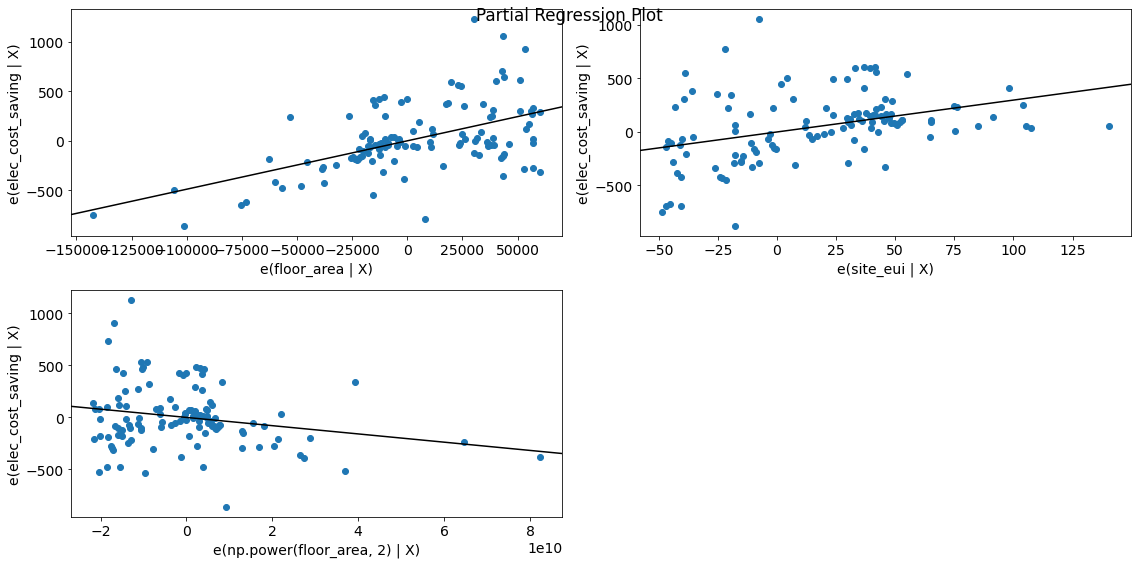

In [402]:
plt.rc("figure", figsize=(16,8))
plt.rc("font", size=14)

fig = sm.graphics.plot_partregress_grid(res1)
fig.tight_layout(pad=1.0)

In [403]:
# Select only medium multi-family 
multi_medium = unique[(unique["type"]=="Multifamily Housing")]
multi_medium.shape

KeyError: ignored

In [353]:
# Selecting regression x_variables
xvariables1 = multi_medium[["BUILDING.ID", "floor_area", "site_eui", "annual_water"]]

# Scale data
#scaler = MinMaxScaler()
#scaler.fit(xvariables[["floor_area", "site_eui", "annual_water"]])
#xvariables[["floor_area", "site_eui", "annual_water"]] = scaler.transform(xvariables[["floor_area","site_eui","annual_water"]])

In [354]:
# Predicting # of HVAC Units
xvariables1['pred_elec_cost_saving_CDIMF'] = res1.predict(xvariables1[["floor_area","site_eui","annual_water"]])
pd.set_option('display.max_rows', 50)
xvariables1

,BUILDING.ID,floor_area,site_eui,annual_water,pred_elec_cost_saving_CDIMF
0,4.746090e+11,16526.0,48.9,7.893927,433.406413
1,4.748810e+11,21096.0,11.8,2.269228,222.160820
2,4.767420e+11,27000.0,11.6,2.207270,256.285370
4,4.654680e+11,24234.0,5.9,2.609288,234.859577
5,4.703840e+11,19151.0,22.7,5.015531,308.420243
...,...,...,...,...,...
490,4.757900e+11,37855.0,16.0,0.253943,283.104562
491,4.022580e+11,105000.0,1.1,0.644844,618.851785
493,4.794840e+11,21252.0,21.9,5.530198,332.486094
494,4.403760e+11,42864.0,3.5,1.113414,302.137688


In [355]:
import statistics
df = xvariables1['pred_elec_cost_saving_CDIMF']
np.nanmedian(df)

276.41408620036225

In [356]:
multifam_mean = (np.mean(df))
multifam_mean

365.9139798895292

In [357]:
df.sum()

144536.02205636405

In [358]:
pred_elec_cost_saving_CDIMF = xvariables1[['BUILDING.ID','pred_elec_cost_saving_CDIMF']]
pred_elec_cost_saving_CDIMF

,BUILDING.ID,pred_elec_cost_saving_CDIMF
0,4.746090e+11,433.406413
1,4.748810e+11,222.160820
2,4.767420e+11,256.285370
4,4.654680e+11,234.859577
5,4.703840e+11,308.420243
...,...,...
490,4.757900e+11,283.104562
491,4.022580e+11,618.851785
493,4.794840e+11,332.486094
494,4.403760e+11,302.137688


OFFICE


In [359]:
# Selecting only multi-family housing
regdata2 = merged[(merged["building type"] == "Small Office") | 
                  (merged["building type"] == "Medium Office") | 
                  (merged["building type"] == "Large Office")]
regdata2.shape

(117, 110)

In [360]:
regdata2 = regdata2[["elec_cost_saving","floor_area","site_eui","annual_water"]]

# Scaling the data
scaler = MinMaxScaler()
scaler.fit(regdata2[["floor_area","site_eui","annual_water"]])
regdata2[["floor_area","site_eui","annual_water"]] = scaler.transform(regdata2[["floor_area","site_eui","annual_water"]])

regdata2.head()

,elec_cost_saving,floor_area,site_eui,annual_water
1,174002.74,0.129802,0.424684,0.804878
11,79559.96,0.046135,0.555209,0.853659
15,112716.30,0.078254,0.447290,0.853659
17,51860.10,0.039085,0.069488,0.829268
19,93407.22,0.065227,0.456016,0.853659


In [361]:
# Regression model
res2 = smf.ols('elec_cost_saving ~ floor_area + site_eui + np.power(floor_area,2) -1 + annual_water', data=regdata2).fit()
print(res2.summary())

                                 OLS Regression Results                                
Dep. Variable:       elec_cost_saving   R-squared (uncentered):                   0.989
Model:                            OLS   Adj. R-squared (uncentered):              0.989
Method:                 Least Squares   F-statistic:                              2530.
Date:                Thu, 01 Apr 2021   Prob (F-statistic):                   1.55e-109
Time:                        06:12:16   Log-Likelihood:                         -1413.2
No. Observations:                 117   AIC:                                      2834.
Df Residuals:                     113   BIC:                                      2845.
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
                              coef    std err          t      P>|t|      [0.025      0.975]
----------------------------

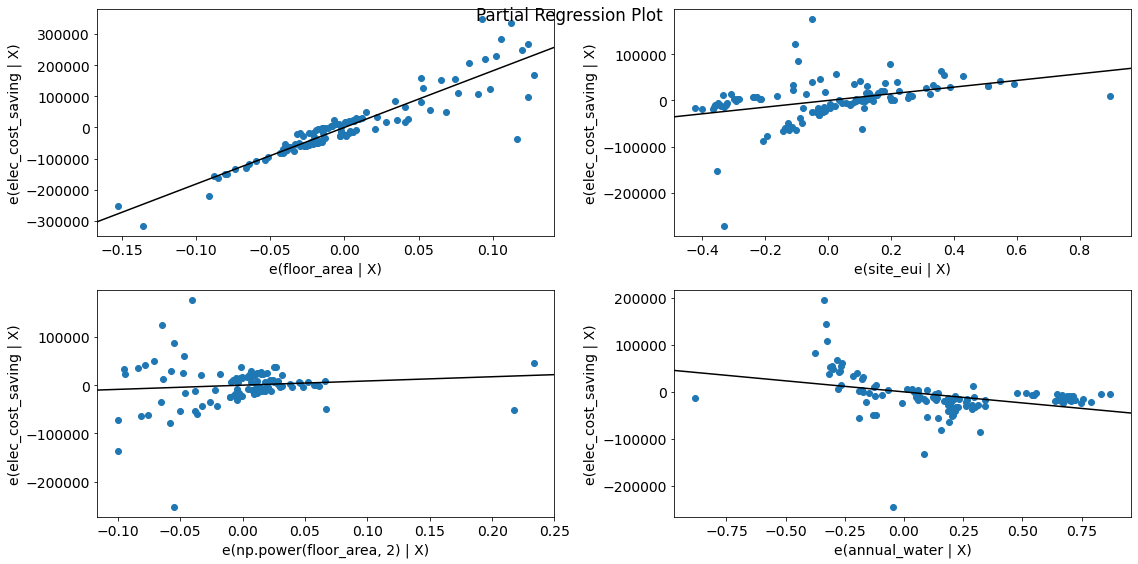

In [362]:
plt.rc("figure", figsize=(16,8))
plt.rc("font", size=14)

fig = sm.graphics.plot_partregress_grid(res2)
fig.tight_layout(pad=1.0)

In [363]:
# Select only medium multi-family 
e_offices = unique[(unique["type"]=="Office")]
e_offices.shape

(70, 13)

In [364]:
# Selecting regression x_variables
xvariables2 = e_offices[["BUILDING.ID","floor_area","site_eui","annual_water"]]

# Scale data
scaler = MinMaxScaler()
scaler.fit(xvariables2[["floor_area","site_eui","annual_water"]])
xvariables2[["floor_area","site_eui","annual_water"]] = scaler.transform(xvariables2[["floor_area","site_eui","annual_water"]])

In [365]:
# Predicting gas cost savings
xvariables2['pred_elec_cost_saving_CDIOFF'] = res2.predict(xvariables2[["floor_area","site_eui","annual_water"]])
pd.set_option('display.max_rows', 100)
xvariables2

,BUILDING.ID,floor_area,site_eui,annual_water,pred_elec_cost_saving_CDIOFF
3,4.774660e+11,0.171336,0.310292,0.000577,3.362426e+05
13,4.208850e+11,0.099135,0.546851,0.005645,2.201620e+05
15,4.047380e+11,0.192787,0.221198,0.001052,3.694564e+05
18,3.822820e+11,0.206516,0.172043,0.000002,3.913877e+05
19,3.822710e+11,0.533253,0.027650,0.000138,9.957584e+05
20,3.821670e+11,0.096999,0.374808,0.000004,2.041040e+05
21,3.784170e+11,0.094235,0.576037,0.010799,2.130374e+05
22,3.897040e+11,0.438682,0.096774,0.001296,8.208285e+05
23,3.905750e+11,0.484012,0.092166,0.001261,9.065130e+05
27,3.845130e+11,0.125646,0.218126,0.000459,2.453965e+05


In [366]:
df = xvariables2["pred_elec_cost_saving_CDIOFF"]
office_median = (np.nanmedian(df))
office_median

250653.38331201728

In [367]:
office_mean = (np.mean(df))
office_mean

348606.9028253752

In [368]:
df.sum()

24053876.294950884

In [369]:
pred_elec_cost_saving_CDIOFF = xvariables2[['BUILDING.ID','pred_elec_cost_saving_CDIOFF']]
pred_elec_cost_saving_CDIOFF

,BUILDING.ID,pred_elec_cost_saving_CDIOFF
3,4.774660e+11,3.362426e+05
13,4.208850e+11,2.201620e+05
15,4.047380e+11,3.694564e+05
18,3.822820e+11,3.913877e+05
19,3.822710e+11,9.957584e+05
20,3.821670e+11,2.041040e+05
21,3.784170e+11,2.130374e+05
22,3.897040e+11,8.208285e+05
23,3.905750e+11,9.065130e+05
27,3.845130e+11,2.453965e+05


RETAIL




In [370]:
# Selecting only multi-family housing
retail = merged[(merged["building type"] == "Small Retail") | 
                 (merged["building type"] == "Medium Retail") | 
                 (merged["building type"] == "Large Retail")]
retail.shape

(8, 110)

In [371]:
regdata3 = retail[["elec_cost_saving","floor_area","site_eui","annual_water"]]

# Scaling the data
scaler = MinMaxScaler()
scaler.fit(regdata3[["floor_area","site_eui","annual_water"]])
regdata3[["floor_area","site_eui","annual_water"]] = scaler.transform(regdata3[["floor_area","site_eui","annual_water"]])

regdata3.head()

,elec_cost_saving,floor_area,site_eui,annual_water
105,55001.94,0.812663,0.068204,0.999919
209,13190.69,0.002166,1.000000,0.000808
243,34472.45,0.450261,0.000000,0.999758
317,11462.94,0.000000,0.802666,0.000000
351,24323.49,0.210197,0.330205,1.000000


In [372]:
# Regression model
res3 = smf.ols('elec_cost_saving ~ floor_area + site_eui + np.power(floor_area,2) -1 +annual_water', data=regdata3).fit()
print(res3.summary())

                                 OLS Regression Results                                
Dep. Variable:       elec_cost_saving   R-squared (uncentered):                   0.990
Model:                            OLS   Adj. R-squared (uncentered):              0.980
Method:                 Least Squares   F-statistic:                              99.07
Date:                Thu, 01 Apr 2021   Prob (F-statistic):                    0.000298
Time:                        06:13:17   Log-Likelihood:                         -78.706
No. Observations:                   8   AIC:                                      165.4
Df Residuals:                       4   BIC:                                      165.7
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
                              coef    std err          t      P>|t|      [0.025      0.975]
----------------------------

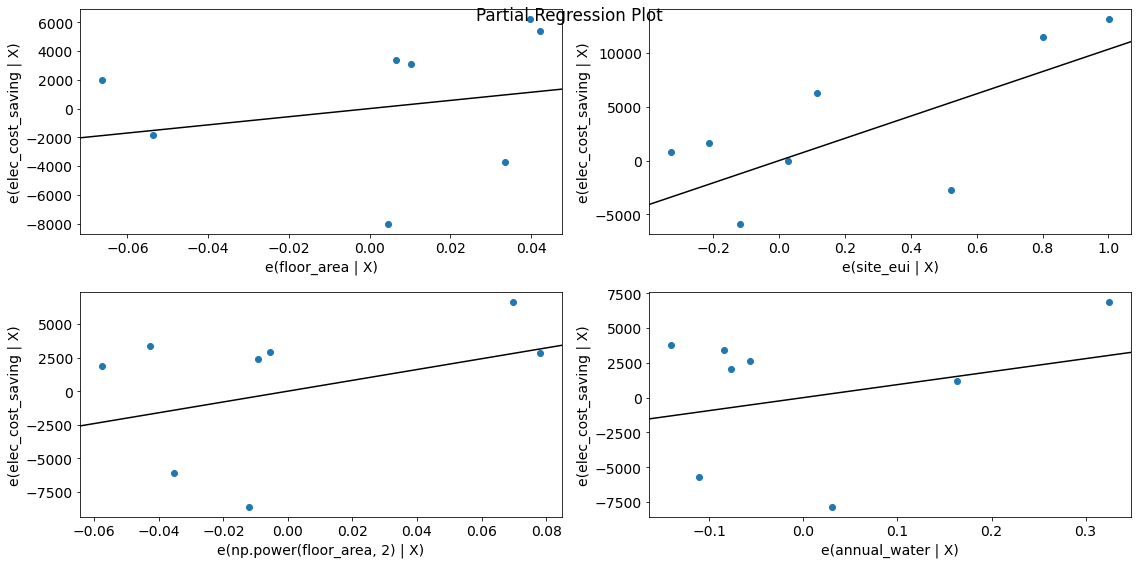

In [373]:
plt.rc("figure", figsize=(16,8))
plt.rc("font", size=14)

fig = sm.graphics.plot_partregress_grid(res3)
fig.tight_layout(pad=1.0)

In [374]:
# Select only medium multi-family 
e_retail = unique[(unique["type"]=="Retail Store")]
e_retail.shape

(17, 13)

In [375]:
# Selecting regression x_variables
xvariables3 = e_retail[["BUILDING.ID", "floor_area", "site_eui","annual_water"]]

# Scale data
scaler = MinMaxScaler()
scaler.fit(xvariables3[["floor_area","site_eui","annual_water"]])
xvariables3[["floor_area","site_eui","annual_water"]] = scaler.transform(xvariables3[["floor_area","site_eui","annual_water"]])

In [376]:
# Predicting gas cost saving
xvariables3['pred_elec_cost_saving_CDIRET'] = res3.predict(xvariables3[["site_eui","floor_area","annual_water"]])
pd.set_option('display.max_rows', 100)
xvariables3

,BUILDING.ID,floor_area,site_eui,annual_water,pred_elec_cost_saving_CDIRET
26,3.893480e+11,0.124255,0.295806,0.118512,8308.149025
66,4.381130e+11,0.164430,0.205298,0.001531,7885.258489
111,4.204640e+11,0.112752,0.514349,0.038736,9386.182225
146,3.816400e+11,0.785235,0.008830,0.000942,47174.349982
157,3.835090e+11,0.382550,0.388521,0.202756,22643.530329
169,4.035110e+11,0.681879,0.139073,0.011973,39590.973589
221,4.573600e+11,0.294309,0.090508,0.356840,16097.312176
266,4.869630e+11,0.114094,0.052980,0.107575,5310.419506
268,4.848280e+11,0.532617,0.075055,NaN,NaN
270,4.850130e+11,0.132752,0.000000,0.321400,7474.500410


In [377]:
df = xvariables3["pred_elec_cost_saving_CDIRET"]
retail_median = (np.nanmedian(df))
retail_median

14377.273533711006

In [378]:
retail_mean = (np.mean(df))
retail_mean

20797.121349039277

In [379]:
df.sum()

332753.9415846285

In [380]:
pred_elec_cost_saving_CDIRET = xvariables3[['BUILDING.ID','pred_elec_cost_saving_CDIRET']]
pred_elec_cost_saving_CDIRET

,BUILDING.ID,pred_elec_cost_saving_CDIRET
26,3.893480e+11,8308.149025
66,4.381130e+11,7885.258489
111,4.204640e+11,9386.182225
146,3.816400e+11,47174.349982
157,3.835090e+11,22643.530329
169,4.035110e+11,39590.973589
221,4.573600e+11,16097.312176
266,4.869630e+11,5310.419506
268,4.848280e+11,NaN
270,4.850130e+11,7474.500410


In [381]:
df_final = pd.concat([pred_elec_cost_saving_CDIRET, pred_elec_cost_saving_CDIOFF, pred_elec_cost_saving_CDIMF], axis = 0)
df_final

,BUILDING.ID,pred_elec_cost_saving_CDIRET,pred_elec_cost_saving_CDIOFF,pred_elec_cost_saving_CDIMF
26,3.893480e+11,8308.149025,NaN,NaN
66,4.381130e+11,7885.258489,NaN,NaN
111,4.204640e+11,9386.182225,NaN,NaN
146,3.816400e+11,47174.349982,NaN,NaN
157,3.835090e+11,22643.530329,NaN,NaN
...,...,...,...,...
490,4.757900e+11,NaN,NaN,283.104562
491,4.022580e+11,NaN,NaN,618.851785
493,4.794840e+11,NaN,NaN,332.486094
494,4.403760e+11,NaN,NaN,302.137688


In [382]:
cols = ['pred_elec_cost_saving_CDIRET', 'pred_elec_cost_saving_CDIOFF', 'pred_elec_cost_saving_CDIMF']
export_df = df_final.assign(pred_elec_cost_saving_CDI=df_final[cols].sum(1)).drop(cols, 1)
export_df

,BUILDING.ID,pred_elec_cost_saving_CDI
26,3.893480e+11,8308.149025
66,4.381130e+11,7885.258489
111,4.204640e+11,9386.182225
146,3.816400e+11,47174.349982
157,3.835090e+11,22643.530329
...,...,...
490,4.757900e+11,283.104562
491,4.022580e+11,618.851785
493,4.794840e+11,332.486094
494,4.403760e+11,302.137688


In [383]:
export_df.to_csv('energy_cost_saving_CDI.csv', index = False)

Combining all cost savings for CDI/AC OPT to one single data frame.

In [416]:
energy_cost_saving_CDI1 = pd.read_csv("energy_cost_saving_ACOPT.csv")
elec_cost_saving_CDI1 = pd.read_csv("elec_cost_saving_ACOPT.csv")
gas_cost_saving_CDI1 = pd.read_csv("gas_cost_saving_ACOPT.csv")

In [417]:
dfs = [energy_cost_saving_CDI1, elec_cost_saving_CDI1, gas_cost_saving_CDI1]

In [418]:
from functools import reduce
df_final = reduce(lambda left,right: pd.merge(left,right,on='BUILDING.ID'), dfs)
df_final

,BUILDING.ID,pred_energy_cost_saving_ACOPT,pred_elec_cost_saving_ACOPT,pred_gas_cost_saving_ACOPT
0,370244899060,14556.902630,14586.407113,-29.503718
1,378702892165,39246.947647,39577.155211,-330.205789
2,379072892713,78526.360285,80107.639437,-1581.276465
3,379328891539,70655.464129,71769.118613,-1113.651944
4,381005916882,24286.453128,24227.605678,58.848422
...,...,...,...,...
2150,999000000426,630.683665,347.763312,282.920376
2151,999000000494,1733.181465,1103.353694,629.829042
2152,999000000495,1578.596000,1050.821066,527.776712
2153,999000000496,2308.570406,1086.654466,1221.912269


In [419]:
correct_df = df_final.rename(columns={"pred_elec_cost_saving_CDI_x": "pred_energy_cost_saving_ACOPT", 
                                "pred_elec_cost_saving_CDI_y": "pred_elec_cost_saving_ACOPT", 
                                "pred_elec_cost_saving_CDI": "pred_gas_cost_saving_ACOPT"})
correct_df

,BUILDING.ID,pred_energy_cost_saving_ACOPT,pred_elec_cost_saving_ACOPT,pred_gas_cost_saving_ACOPT
0,370244899060,14556.902630,14586.407113,-29.503718
1,378702892165,39246.947647,39577.155211,-330.205789
2,379072892713,78526.360285,80107.639437,-1581.276465
3,379328891539,70655.464129,71769.118613,-1113.651944
4,381005916882,24286.453128,24227.605678,58.848422
...,...,...,...,...
2150,999000000426,630.683665,347.763312,282.920376
2151,999000000494,1733.181465,1103.353694,629.829042
2152,999000000495,1578.596000,1050.821066,527.776712
2153,999000000496,2308.570406,1086.654466,1221.912269


In [420]:
correct_df.to_csv('cost_saving_ACOPT.csv', index = False)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')